# Extending the Mario Level Markov Chain Dataset with Image Processing
Super Mario Brothers' (SMB) worlds each follow a certain theme, with different blocks, enemies and backgrounds. Not only that, the levels scale in complexity in terms of difficulty. The provided code uses the levels across all worlds of two different SMB games in order to model the dependencies between a block and its neighbours in a 2x2 square. The result is that there is no consistency in design or difficulty of the levels - which is unlike a SMB game.

In order to more closely model a certain SMB game world, a more representative level sample will be needed. I mean to provide this extension by scraping the internet for images of the game, and represent these in a vectorized format from which we can again learn the Markovian property. In particular, I will scrape the [NES maps](www.nesmaps.com) website in order to extend the dataset of Super Mario Bros (SMB) levels we currently have representations for.

## Prerequisites
First run `pip install jupyter` on a fresh conda environment (or your environment of choice).

## Let's see if we can parse a single image
I sourced a sample PNG image from [NES Super Mario Brothers 2 (Japan), world 1-1](https://nesmaps.com/maps/SuperMarioBrothers2j/SuperMarioBros2jMap1-1BG.html). We already have this map in our dataset, which will be useful for evaluating our technique.

In [62]:
%%capture
!pip install opencv-python
!pip install numpy
!pip install matplotlib
!pip install requests
!pip install beautifulsoup4

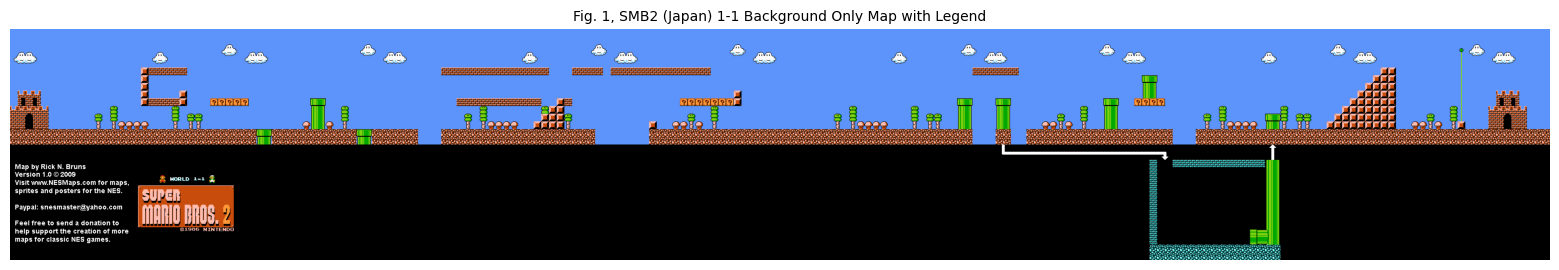

In [63]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

filepath = "Scraped/notebook_examples/SuperMarioBros2jMap1-1BG.png"

img = cv2.cvtColor(cv2.imread(filepath), cv2.COLOR_BGR2RGB) # load the image in the color space we want (RGB)

# Let's display the image that we have downloaded
iheight, iwidth, _ = img.shape
aspect_ratio = iheight / iwidth
scaling_factor = 20
fig = plt.figure(figsize=(1/aspect_ratio * scaling_factor, aspect_ratio * scaling_factor)) # Just making it a bit bigger
plt.axis('off')
plt.title('Fig. 1, SMB2 (Japan) 1-1 Background Only Map with Legend', fontdict={'fontsize': 10})
plt.imshow(img)
plt.show()

Here we have a SMB2 level as an image, which should have all the information that we need about the tiles and their placements. Now, how do we extract the tile information from this?

The first step would be to determine the dimensions of a single block in our grid, so that we can split our world along this grid.
- Some potential pain-points I am already seeing are these arrows that represent teleportation locations. Running `visualize.py` with the textual representation from our dataset, we can see that this was in-fact ignored in the representation.

### What are the dimensions of one block in our grid?
**The first thing that we can try is to compare size of the image to our textual representations**: we can leverage the textual description of the same level, and compare that to the image. If we can extrapolate $a$ from $$shape(text\_representation) == a \cdot shape(img)$$ then we can imagine that our blocks would be $a \times a$ pixels

In [64]:
with open("SMB2_Data/Processed/SuperMarioBros2(J)-World1-1.txt") as level_text_f:
    level_1_1 = [list(row) for row in level_text_f] # Turn the map into a 2D matrix

level_1_1 = np.array(level_1_1)
lheight, lwidth = level_1_1.shape
iheight/lheight, iwidth/lwidth

(34.285714285714285, 17.391304347826086)

That is not what we wanted to see... there are fractional parts in both parts. Which can likely be explained by the underground segment along the height, and by the exclusion of the start and the end of the level in the width. We will need to try something else.

**The second thing we can try is to see if the image is in a standard size**: that is, the sprites in the image are actually the size of the sprites in-game. We can easily check this because the website I am using provides a list of some sprites and their dimensions. Notably, they mention that the sprite for a basic block has dimensions 16x16 pixels.

In [65]:
iheight/16, iwidth/16

(30.0, 200.0)

Now that is more like it! We can see that our image has a height of 30 (16px) blocks and a width of 200 (16px) blocks. We can therefore describe our image as 30x200 blocks to represent.

Let's try to represent this, first we can do so using OpenCV, but we will also want to partition our image array into these same blocks.

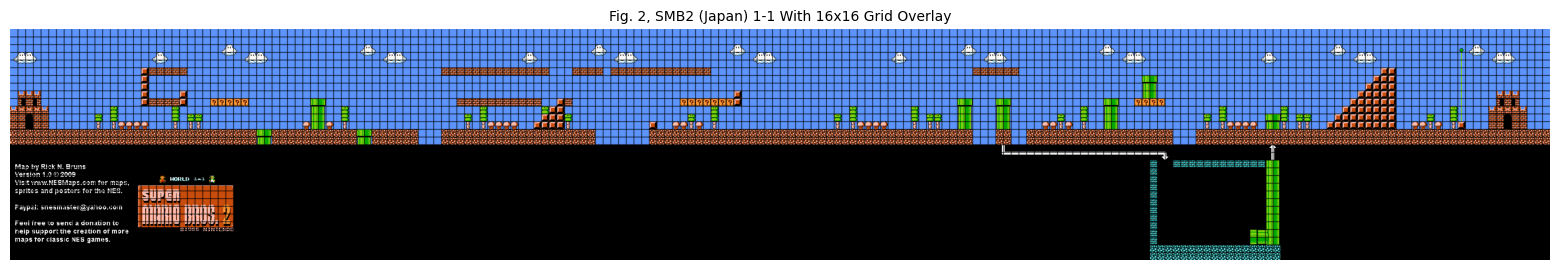

In [66]:
def draw_grid(image, line_color=(0, 0, 0), thickness=1, type=cv2.LINE_AA, step=50):
    """
    Code adapted from StackOverflow https://stackoverflow.com/a/49807766
    Draw gridlines on img
    :param image: To draw gridlines over
    :param line_color: RGB representation of colour
    :param thickness: line thickness
    :param type: 8, 4 or cv2.LINE_AA
    :param step: grid line frequency in pixels
    """
    x = y = step
    height, width, _ = image.shape
    while x < width:
        cv2.line(image, (x, 0), (x, image.shape[0]), color=line_color, lineType=type, thickness=thickness)
        x += step
    while y < height:
        cv2.line(image, (0, y), (image.shape[1], y), color=line_color, lineType=type, thickness=thickness)
        y += step

grid_img = img.copy()
draw_grid(grid_img, step=16)
fig = plt.figure(figsize=(1/aspect_ratio * scaling_factor, aspect_ratio * scaling_factor)) # Just making it a bit bigger
plt.axis('off')
plt.title('Fig. 2, SMB2 (Japan) 1-1 With 16x16 Grid Overlay', fontdict={'fontsize': 10})
plt.imshow(grid_img)
plt.show()

At a glance, again this looks promising. I will partition the image array in the same fashion in order to extract different 16x16 images. What will be interesting is to try to represent all the unique 16x16 blocks that we have.

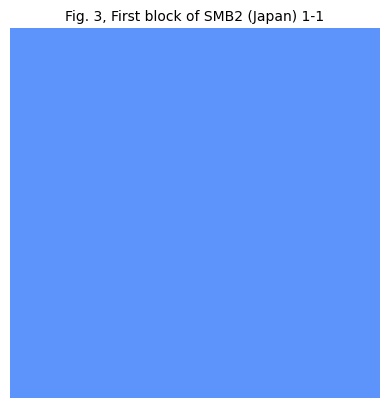

In [67]:
plt.axis('off')
plt.title('Fig. 3, First block of SMB2 (Japan) 1-1', fontdict={'fontsize': 10})
plt.imshow(img[0:16, 0:16, ::])
plt.show()

All blue sky ahead (Fig. 3)! But really we would like to see if this looks right on a block that is not all a single colour.

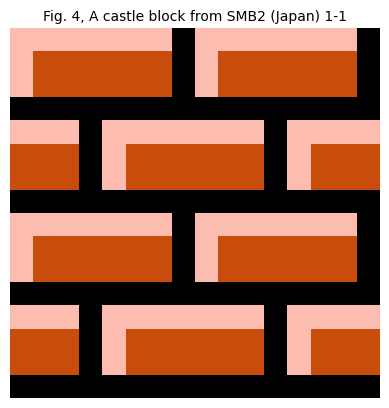

In [68]:
def grid_split(image, block_size=16):
    """
    Splits an image into block-size granulars, changing the overall resolution to that of the block
    :param image: To split into blocks
    :param block_size: Number of pixels in a BxB chunk
    """
    h, w, _ = image.shape
    split = np.zeros((h // block_size, w // block_size, block_size, block_size, 3), dtype=np.int32)
    for x in range(block_size, w + 1, block_size):
        for y in range(block_size, h + 1, block_size):
            block_index = y // block_size - 1, x // block_size - 1
            split[block_index] = image[y - block_size:y, x - block_size:x, :]
    return split


blocks = grid_split(img)

# Using the image as reference for the index, I will try to display instead one of the castle blocks (12, 0) should have some castle
plt.axis('off')
plt.title('Fig. 4, A castle block from SMB2 (Japan) 1-1', fontdict={'fontsize': 10})
plt.imshow(blocks[12, 0])
plt.show()

It seems like the dimensions (16x16) for our grid are correct.

## Extracting all unique sprite blocks
Now it will be interesting to know the vocabulary of our world, what are all the unique sprites that we have in our world? I can see that there will be some issues right out of the gate, notably - there is a watermark containing world information and some extra text about the author (Rick N. Bruns). We can imagine perhaps a count-based solution removing blocks that only appear once will remove all of these extra unwanted blocks.

In [69]:
import numpy as np
import matplotlib.pyplot as plt
import math

def show_unique_blocks(blocks, n_cols=16, title=""):
    """
    Represent all unique chunks from a set of blocks
    """
    m, n, block_size, _, channels = blocks.shape
    # Represent blocks each as their BsxBsxC values in order to verify their uniqueness)
    flattened_blocks = blocks.reshape(-1, block_size * block_size * channels)
    unique_flattened_blocks = np.unique(flattened_blocks, axis=0)
    # Bring the blocks back to the original shape
    unique_blocks = unique_flattened_blocks.reshape(-1, block_size, block_size, channels)

    print(f"Number of unique blocks: {len(unique_blocks)}")

    n_blocks = len(unique_blocks)
    n_rows = math.ceil(n_blocks / n_cols)
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 16))

    axes = axes.flatten() # Makes it easier for indexing
    for i, block in enumerate(unique_blocks):
        axes[i].imshow(block)
        axes[i].axis('off')  # Turn off axis for a cleaner look

    # Hide unused plots
    for j in range(i+1, len(axes)):
        fig.delaxes(axes[j])

    plt.suptitle(title, fontsize=20)
    plt.tight_layout()
    plt.show()

Number of unique blocks: 279


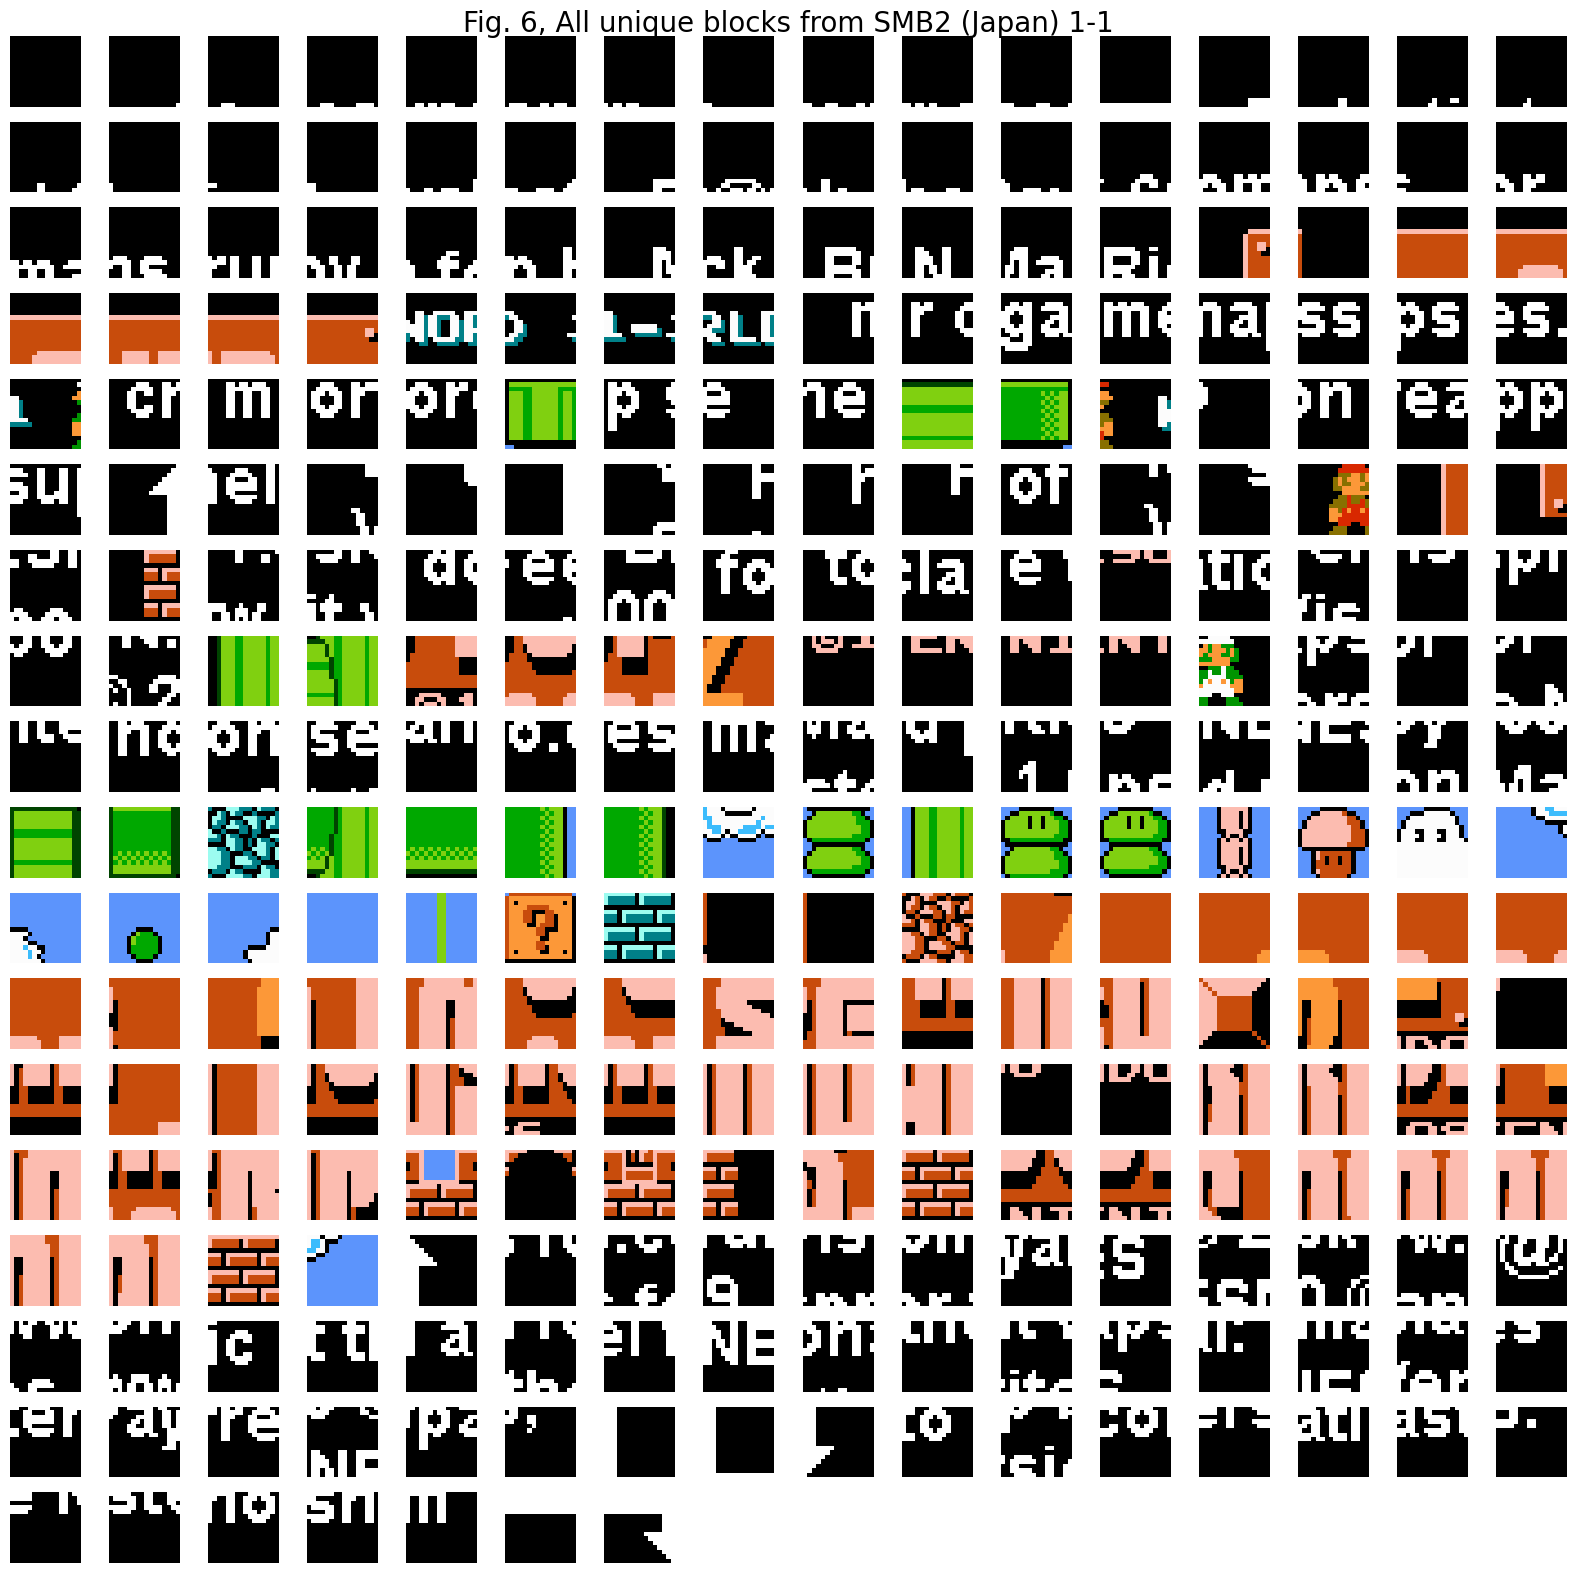

In [70]:
show_unique_blocks(blocks, title='Fig. 6, All unique blocks from SMB2 (Japan) 1-1')

Looking at the data I realize that my count-based solution will not work, there are certain blocks that only appear once blocks which we would not like to remove, like the top of the pole. One simple solution, is that we use some heuristics for filtering, e.g. removing all blocks that only have black and white. However, we will need to write quite a few of these, and it seems troublesome to do across many levels confidently.

A second solution could be to partition the image into two sections, above and below ground, and only focus on the section without text. However, I really wanted to see if we could recreate underground sections (including teleportation arrows).

The last solution may in fact be the simplest and most desirable. The blocks we would like to remove are essentially the same per level minus small deviations in the world and level number. One could imagine fuzzy pattern matching would likely work in this scenario. Taking an exemplar of the watermark and then matching it up to some distance on each image.

In [71]:
watermark = cv2.cvtColor(cv2.imread("Scraped/watermark.png"), cv2.COLOR_BGR2RGB)
watermark.shape

(166, 457, 3)

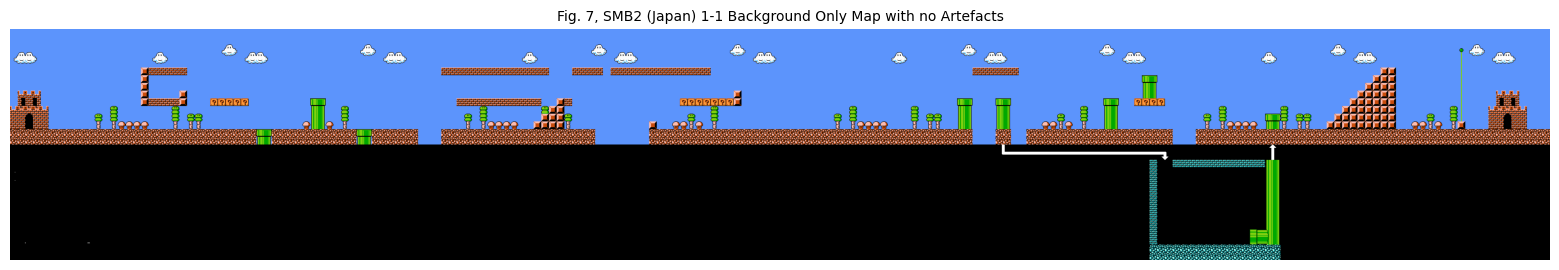

In [72]:
min_val, _, min_location, _ = cv2.minMaxLoc(cv2.matchTemplate(img, watermark, cv2.TM_SQDIFF))
processed_img = img.copy()
x, y = min_location
processed_img[y:y + watermark.shape[0], x:x + watermark.shape[1]] = np.zeros_like(watermark)

fig = plt.figure(figsize=(1/aspect_ratio * scaling_factor, aspect_ratio * scaling_factor)) # Just making it a bit bigger
plt.axis('off')
plt.title('Fig. 7, SMB2 (Japan) 1-1 Background Only Map with no Artefacts', fontdict={'fontsize': 10})
plt.imshow(processed_img)
plt.show()

Number of unique blocks: 55


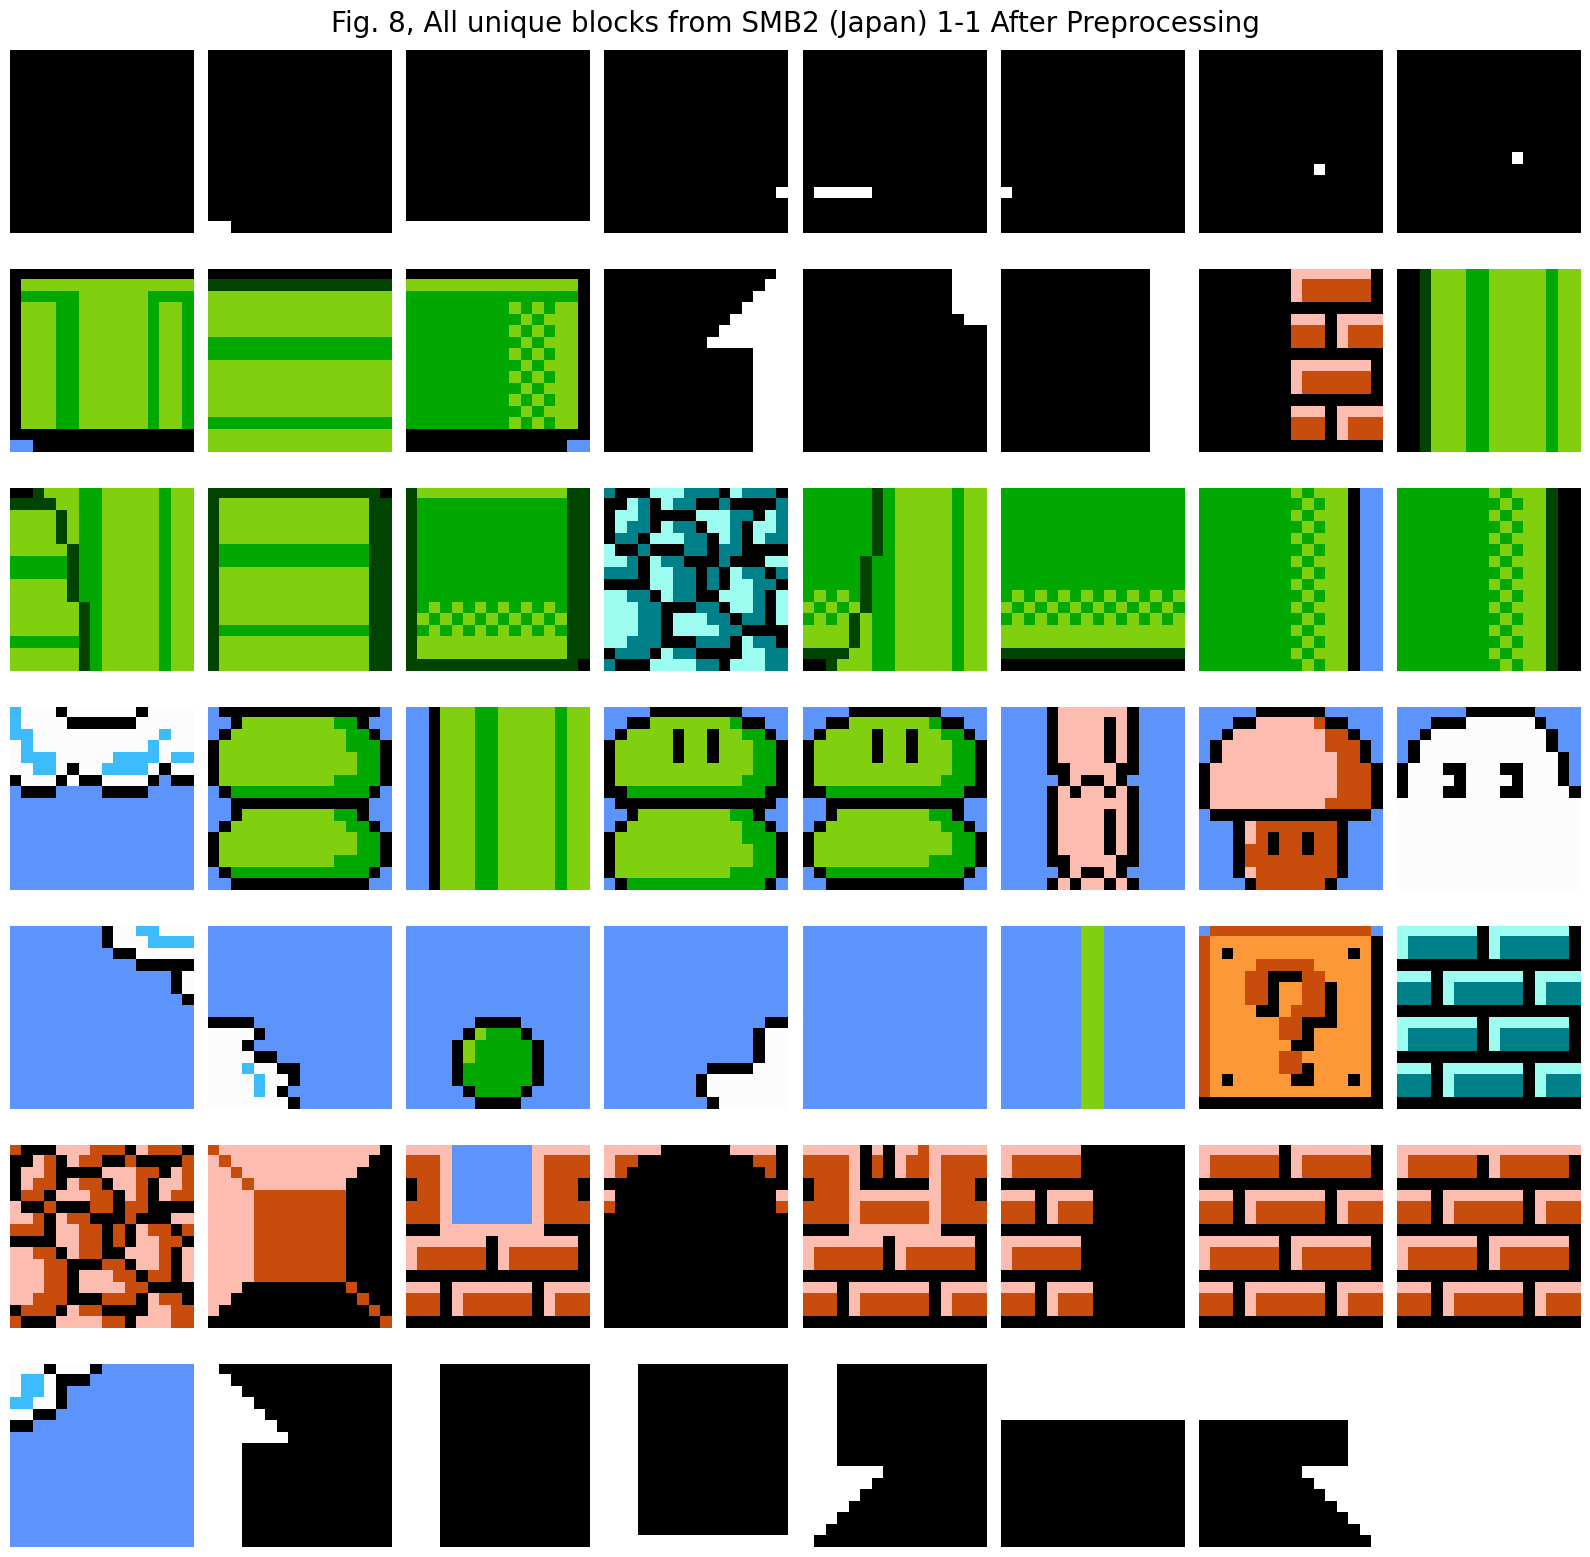

In [73]:
blocks_p = grid_split(processed_img)
show_unique_blocks(blocks_p, title='Fig. 8, All unique blocks from SMB2 (Japan) 1-1 After Preprocessing', n_cols=8)

There is much less noise here - though there are still some artefacts that I am unsure about, notably in that top row. There are a couple of blocks that are just white blocks. Let's do some encoding to get a lower level representation, then we can see where these come from.

In [74]:
m, n, block_size, _, channels = blocks_p.shape
flattened_blocks = blocks_p.reshape(-1, block_size * block_size * channels)
unique_flattened_blocks, inverse = np.unique(flattened_blocks, axis=0, return_inverse=True)
unique_blocks = unique_flattened_blocks.reshape(-1, block_size, block_size, channels)
ohe = inverse.reshape(m, n).astype(np.int8) # Index into the unique flattened blocks array

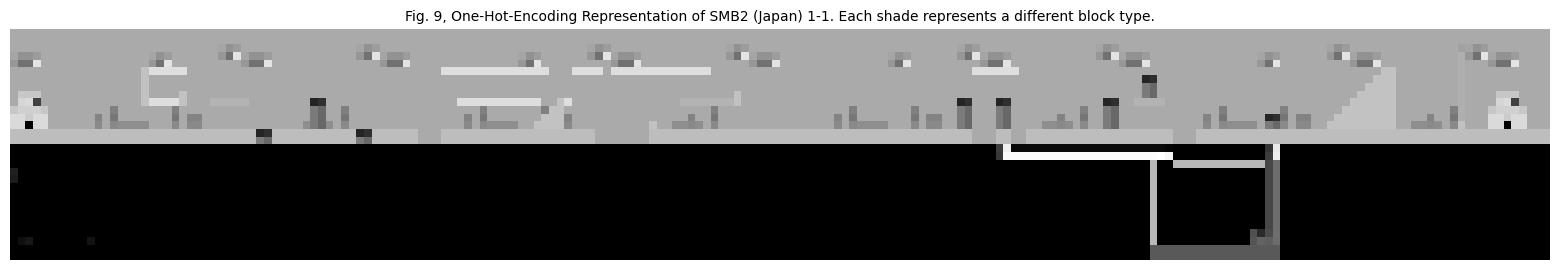

In [75]:
fig = plt.figure(figsize=(1/aspect_ratio * scaling_factor, aspect_ratio * scaling_factor)) # Just making it a bit bigger
plt.axis('off')
plt.title('Fig. 9, One-Hot-Encoding Representation of SMB2 (Japan) 1-1. Each shade represents a different block type.', fontdict={'fontsize': 10})
plt.imshow(ohe, cmap='gray')
plt.show()

So this is pretty cool! We reduced our original image which was 3200×480x3 -> [0, 255] into an encoding of 30x200 -> [0, 64].

In [76]:
print(f"The original image was {img.nbytes} bytes, and our representation takes up {ohe.nbytes} bytes. The compression rate of this representation therefore amounts to {img.nbytes//ohe.nbytes}:1, which is 16x16x3 as expected.")

The original image was 4608000 bytes, and our representation takes up 6000 bytes. The compression rate of this representation therefore amounts to 768:1, which is 16x16x3 as expected.


## Recreating the image from our representation
In order to recreate the image from our representation, all we will need to do is fetch the corresponding 16x16x3 block representation that corresponds to our encoding. Doing the inverse of our grid representation

In [77]:
unique_flattened_blocks.reshape(-1, 16, 16, 3).shape

(55, 16, 16, 3)

In [78]:
def reconstruct_image(ohe, unique_blocks):
    num_blocks_h, num_blocks_w = ohe.shape[0], ohe.shape[1]
    block_size = unique_blocks[0].shape[0]
    reconstructed_image = np.zeros_like(processed_img)

    # Replace each block with the appropriate sprite
    for i in range(num_blocks_h):
        for j in range(num_blocks_w):
            # Find the corresponding segment for this block
            block = unique_blocks[ohe[i, j]]

            reconstructed_image[i*block_size:(i+1)*block_size, j*block_size:(j+1)*block_size, :] = block
    return reconstructed_image

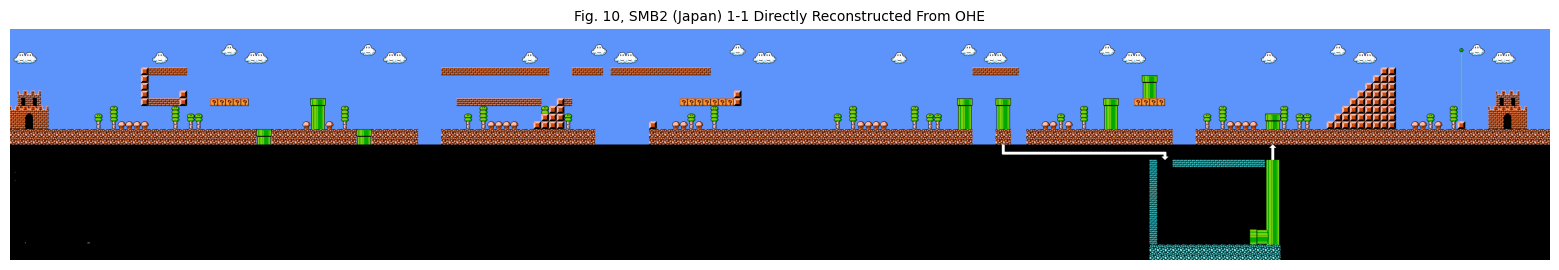

In [79]:
fig = plt.figure(figsize=(1/aspect_ratio * scaling_factor, aspect_ratio * scaling_factor)) # Just making it a bit bigger
plt.axis('off')
plt.title('Fig. 10, SMB2 (Japan) 1-1 Directly Reconstructed From OHE', fontdict={'fontsize': 10})
plt.imshow(reconstruct_image(ohe, unique_blocks), cmap='gray')
plt.show()

## Let's create our scraper
Now that we can handle a single image, all that we will need to do is retrieve all the map images that we are interested in. I am using the guide [Beautiful Soup: Build a Web Scraper With Python](https://realpython.com/beautiful-soup-web-scraper-python/) as a starting point.

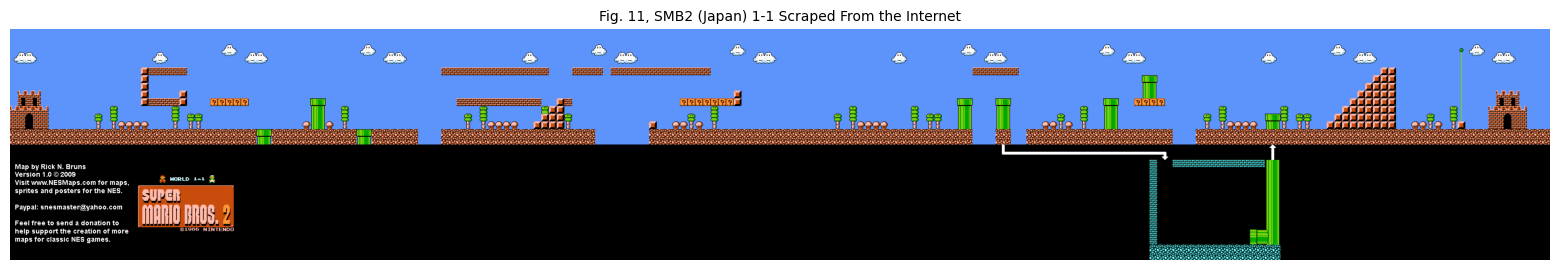

In [80]:
import re
import requests
from bs4 import BeautifulSoup

SMB1 = "SuperMarioBrothers"
title = "SuperMarioBrothers2j"
short = "SuperMarioBros2j"

page = requests.get(f"https://nesmaps.com/maps/{title}/{title}BG.html")

soup = BeautifulSoup(page.content, "html.parser")

# Find all HTML links to map levels and get the ID from the link
img_id = soup.find_all(href=re.compile(f"{short}.*.html"))[0]['href'].split('.html')[0]

# Now we can get the image itself and covert it using OpenCV
response = requests.get(f"https://nesmaps.com/maps/{title}/{img_id}.png")
image_array = np.frombuffer(response.content, np.uint8)
image = cv2.cvtColor(cv2.imdecode(image_array, cv2.IMREAD_COLOR), cv2.COLOR_BGR2RGB)

fig = plt.figure(figsize=(1/aspect_ratio * scaling_factor, aspect_ratio * scaling_factor))
plt.axis('off')
plt.title('Fig. 11, SMB2 (Japan) 1-1 Scraped From the Internet', fontdict={'fontsize': 10})
plt.imshow(image)
plt.show()

## We're done! Let's put it all together
We have all the components for our web-scraper and parser. All that is left to do is to put them together.